In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
from scipy.io import readsav

import datetime
import matplotlib.dates as date

from matplotlib import animation, rc
from IPython.display import HTML

import sys
sys.path.append("../")
from fit2gauss import fit2gauss

In [2]:
path = '/Users/WilliamHenryAshfieldIV/dat/iris/'
filename = 'raster_data.sav'
fn = path+filename

In [3]:
ro = readsav(fn,verbose=False,python_dict=False)

In [4]:
tm = np.array(ro.d['TIME'][0])
ro.d['TIME_CCSDS'][0][0]

b'2014-10-25T14:58:28.730'

In [5]:
sttime = 53908 # observation start time in sec.
tm += sttime

In [6]:
dts = np.empty(len(tm), dtype = '<U15')
for i in range (0,len(tm)):
    dts[i] = str(datetime.timedelta(seconds=tm[i],milliseconds=3))

In [7]:
dts[0]

'14:58:28.173000'

In [8]:
tmp = np.array([datetime.datetime for x in range(len(tm))])
for i in range(0,len(tm)):
    tmp[i]=datetime.datetime.strptime(dts[i],'%H:%M:%S.%f')
tm_d = date.date2num(tmp)

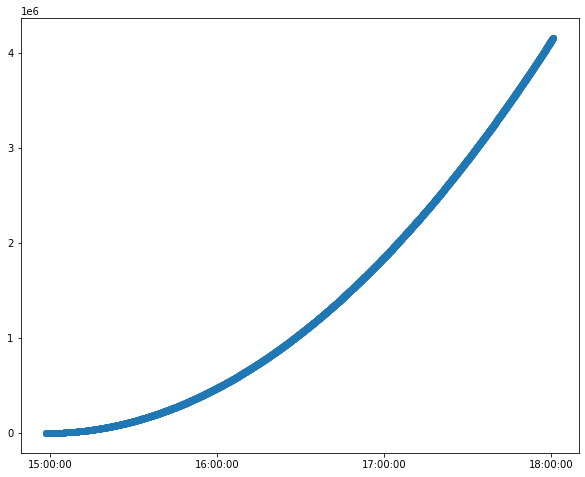

In [9]:
ty = np.arange(0,len(tm))
fig, ax = plt.subplots(figsize=(10,8))
ax.plot_date(tm_d,ty**2)
ax.xaxis.set_major_locator(date.HourLocator())
ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M:%S'))

In [10]:
Int = ro.d['INT'][0]
wvl = ro.d['WVL'][0]
err = ro.d['ERR'][0]

data = Int[69,:,:] # raster px=69, the one we want.
error = err[69,:,:]

# trim:
jj = np.where((wvl > 1402) & (wvl < 1404))[0]
data = data[:,jj]
error = error[:,jj]
wvl = wvl[jj]

In [11]:
Int.shape

(387, 2040, 197)

In [12]:
wvl[0]

1402.014467867996

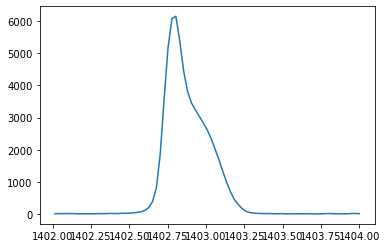

In [13]:
plt.plot(wvl,data[1426,:])

In [16]:
it = np.arange(1200,1600) # subrange of time (in index) to fit
#it = np.arange(1400,1500)
N = len(it)

In [35]:
v_r = np.zeros(N)
v_b = np.zeros(N)
amp = np.zeros(N)

for i in range(0,N):
    
    t_i = it[i]
    dt = data[t_i,:]
    er = error[t_i,:]
        
    res = fit2gauss(wvl,dt,er,chi_thr=40.)
    a2g = res["a2g"] # extract fit parameters
    a1g = res["a1g"]

    #calculate Doppler velocities and wavelengths
    line = 1402.77
    c = 300.
    freq = c/line*1e3

    amp[i] = a1g[0]

    if a2g[1] < a2g[4]:
        v_b[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_r[i] = (a2g[4]-line)/line*3e5
    else:
        v_r[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_b[i] = (a2g[4]-line)/line*3e5

/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(-25566.287890243057, -25566.286711886576)

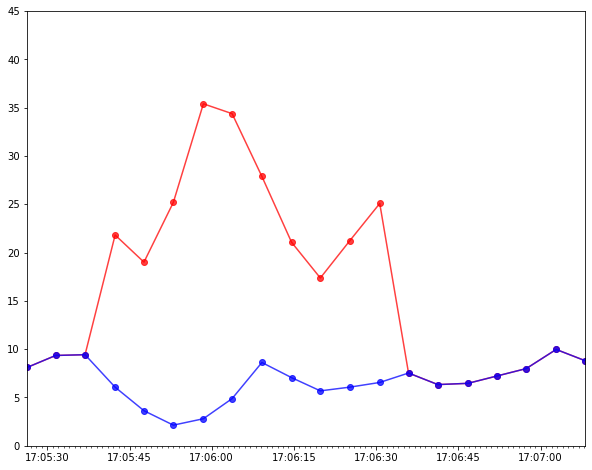

In [48]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot_date(tm_d[it],v_r,'r',alpha=0.75,marker='o')
ax.plot_date(tm_d[it],v_b,'b',alpha=0.75,marker='o')
#ax.xaxis.set_major_locator(date.MinuteLocator())
#ax.xaxis.set_major_locator(tmp[1420:1430])
ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(date.SecondLocator())
#ax.xaxis.set_minor_formatter(date.DateFormatter('0.%f'))
ax.set_ylim(0,45)
ax.set_xlim([tmp[1420], tmp[1439]])

In [74]:
tm -= sttime
stm = tm[1426:1437]
stm -= stm[0] # put time array into seconds, starting at max velocity, for fitting.
vr = v_r[226:237]
stm_d = tm_d[1426:1437]
#plt.plot(stm,vr,'r' 'o')
#plt.ylim(0,50)

In [75]:
from scipy.optimize import curve_fit
def u0_fit(t, *a):
    return a[0]/(1+t/a[1])

In [76]:
a0= [35,15]
popt, pcov = curve_fit(u0_fit, stm, vr,p0=a0)
vr_fit = u0_fit(stm,*popt)

(0.0, 45.0)

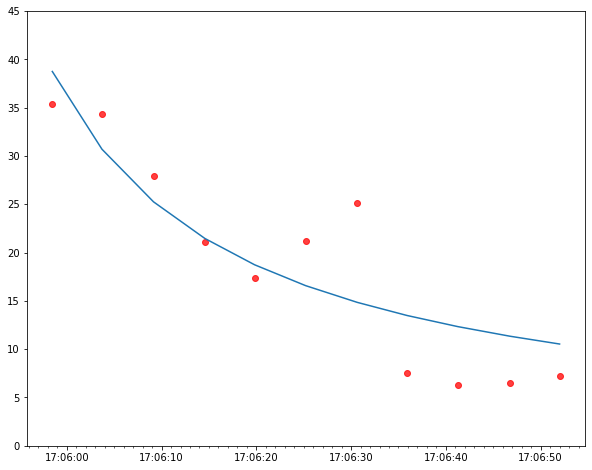

In [78]:
#plt.plot(stm,vr_fit,'-')
#plt.plot(stm,vr,'r' 'o')
#plt.ylim(0,50)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot_date(stm_d,vr,'r' 'o',alpha=0.75)
ax.plot_date(stm_d,u0_fit(stm,*popt),'-')
ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(date.SecondLocator())
ax.set_ylim(0,45)

#plt.plot(stm,u0_fit(stm,*popt),'-')
#plt.plot(stm,vr,'r' 'o')

In [69]:
store = 0
if store == 1:
    vr_iris = vr
    %store vr_fit
    %store vr_iris
    %store stm

In [70]:
H = 0.6*popt[0]*popt[1]
print('H = ', H)
print('tau = ',popt[1])

H =  464.5620697510817
tau =  19.98961380583864


In [72]:
vr

array([35.38914176, 34.37017762, 27.86828955, 21.06021457, 17.36423313,
       21.23268232, 25.0754298 ,  7.53066783,  6.3347912 ,  6.46396827,
        7.21919257,  7.99025657])

In [73]:
vr_fit

array([ 3.87336206e+01,  3.06889405e+01,  2.52455124e+01,  2.14600445e+01,
        1.87340274e+01,  1.65726994e+01,  1.48414002e+01,  1.34844187e+01,
        1.23351104e+01,  1.13413578e+01,  1.05314769e+01, -2.45240553e-03])

In [79]:
dts[1426]

'17:05:58.473000'